# SVM
---

<!-- TABLE OF CONTENTS -->
### Table of Contents: 
1. SVM Defined
2. Optimization of SVM 
     - Gradient Descent for linear SVM and hinge loss 
     - Quadratic programming for Dual Problem & Kernals)
3. Introduction to CVXOPT
4. Converting Dual Form to CVXOPT required form
5. Implimentation of CVXOPT for SVM optimization with Gaussian & Linear Kernal
6. Softmax vs. Hard Margin SVM
7. Comparison with sklearn

<br />

---



### SVM Defined


The Support Vector Machine (SVM) is another form of supervised learning of a classifier. Specifically, SVM's are a type of Margin Maximizer that along with a Kernel form the SVM. 



<br />

---

### Optimization Problem Forms

# 1. Primal Form


# 2. Dual Form

The Dual Form will be our main focus as we can through it into a convex optimizer such as CVXOPT. 

$$
\begin{aligned}
\max _{\alpha} & \; W(\alpha)=\sum_{i=1}^{n} \alpha_{i}-\frac{1}{2} \sum_{i, j=1}^{n} y^{(i)} y^{(j)} \alpha_{i} \alpha_{j}\left\langle x^{(i)}, x^{(j)}\right\rangle .\\
\text { s.t. } & \alpha_{i} \geq 0, \quad i=1, \ldots, n \\
& \sum_{i=1}^{n} \alpha_{i} y^{(i)}=0
\end{aligned}
$$






<br />

---


### Quick SKLearn Implimentation for Reference

---

In [1]:
# Imports

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles
from sklearn.svm import SVC
import numpy as np
from mlxtend.plotting import plot_decision_regions

In [2]:
# This is the very easy way to impliment SVM with Gaussian Kernal and I plan on doing 
# a "from scratch" implimentation along with math behind some of it.


# Create Dataset
# Copied this data set from this acticle: 
# https://towardsdatascience.com/how-to-learn-non-linear-separable-dataset-with-support-vector-machines-a7da21c6d987
np.random.seed(0)

X = np.random.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
y = np.where(y, 1, -1)

# If you want circular data points instead
#X, y = make_circles()


In [3]:
# The very "hard to impliment" model :)

model = SVC(kernel='rbf')
clf = model.fit(X, y)

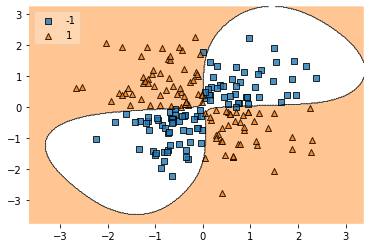

In [4]:
# The mlxtend library for plotting decision is amazing. 

plot_decision_regions(X=X, y=y, clf=clf, legend=2)

plt.show()